## Hierarchical clustering

**Approach 1**

*  AgglomerativeClustering with the cosine distance metric and average linkage.
*  Selects the sentence that is closest to the centroid of the cluster based on the dot product of the sentence vectors and the centroid.



In [6]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from nltk.tokenize import sent_tokenize

In [8]:
def extractive_summary(text, n_clusters=3):
    # Tokenize text into sentences
    sentences = sent_tokenize(text)

    # Compute TF-IDF representation of the sentences
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Perform hierarchical clustering
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
    clustering_model.fit(tfidf_matrix.toarray())

    # Extract representative sentences for each cluster
    cluster_centers = {i: [] for i in range(n_clusters)}
    for idx, label in enumerate(clustering_model.labels_):
        cluster_centers[label].append(idx)

    # Select the most central sentence from each cluster
    summary_sentences = []
    for cluster, indices in cluster_centers.items():
        cluster_vectors = tfidf_matrix[indices].toarray()  # Convert sparse to dense
        centroid = cluster_vectors.mean(axis=0)  # Centroid as a dense array
        similarity_scores = np.dot(cluster_vectors, centroid)  # Dot product
        closest_idx = indices[np.argmax(similarity_scores)]  # Index of the most similar sentence
        summary_sentences.append(sentences[closest_idx])

    # Combine selected sentences to form the summary
    summary = " ".join(summary_sentences)
    return summary

In [9]:
with open("computer_lecture.txt", "r") as file:
    text = file.read()

In [10]:
summary = extractive_summary(text, n_clusters=3)
print("Extractive Summary:\n", summary)

Extractive Summary:
 By understanding their capabilities and limitations, we can harness their potential to create a better world. This involves a sequence of electrical signals that represent the numbers 0 and 1. However, the widespread use of computers is not without challenges.


**Approach 2**

*    AgglomerativeClustering with the cosine distance metric and average linkage.
*   Selects the sentence with the highest TF-IDF score within the cluster (sum of TF-IDF values for each term in the sentence).


In [11]:
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from nltk.tokenize import sent_tokenize

In [12]:
def extractive_summary(text, n_clusters=5):
    # Tokenize text into sentences
    sentences = sent_tokenize(text)

    # Compute TF-IDF representation of the sentences
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Perform hierarchical clustering
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
    clustering_model.fit(tfidf_matrix.toarray())

    # Extract representative sentences for each cluster
    cluster_centers = {i: [] for i in range(n_clusters)}
    for idx, label in enumerate(clustering_model.labels_):
        cluster_centers[label].append(idx)

    # Select the highest TF-IDF scoring sentence from each cluster
    summary_sentences = []
    for cluster, indices in cluster_centers.items():
        cluster_vectors = tfidf_matrix[indices].toarray()
        sentence_scores = cluster_vectors.sum(axis=1)  # Sum of TF-IDF values as a score
        best_sentence_idx = indices[np.argmax(sentence_scores)]
        summary_sentences.append(sentences[best_sentence_idx])

    # Combine selected sentences to form the summary
    summary = " ".join(summary_sentences)
    return summary

In [13]:
with open("computer_lecture.txt", "r") as file:
    text = file.read()

In [14]:
summary = extractive_summary(text, n_clusters=3)
print("Extractive Summary:\n", summary)

Extractive Summary:
 Innovations such as quantum computing and advanced artificial intelligence promise to redefine our understanding of computation and problem-solving. This involves a sequence of electrical signals that represent the numbers 0 and 1. Today, billions of devices are connected via the internet, forming a global network that has fostered innovation and connectivity.


# Clustering using Elbow method

**Approach 1: Manually specifying the number of clusters**


*   The number of clusters is fixed by the user (set as n_clusters). The number of clusters needs to be determined manually before running the code.
*   The elbow method is plotted for a range of clusters (2 to 10), but the number of clusters is manually set afterward(here 4)
*   For each cluster, the sentence with the highest sum of TF-IDF scores is selected as a representative sentence.
*   Distortion (average cosine distance) is calculated for each number of clusters, but it's done for each cluster individually.
*   Works with sparse TF-IDF matrices directly when calculating distortions and performing clustering.







In [15]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from nltk.tokenize import sent_tokenize
from scipy.spatial.distance import cdist

In [16]:
def plot_elbow_method(tfidf_matrix, max_clusters=10):
    distortions = []
    cluster_range = range(2, max_clusters + 1)

    for k in cluster_range:
        clustering_model = AgglomerativeClustering(n_clusters=k, metric='cosine', linkage='average')
        clustering_model.fit(tfidf_matrix.toarray())

        # Calculate the distortion: average cosine distance to the cluster center
        cluster_distortions = []
        labels = clustering_model.labels_
        for label in np.unique(labels):
            cluster_points = tfidf_matrix[labels == label]
            centroid = cluster_points.mean(axis=0).A.flatten()  # Convert sparse matrix to dense array
            cluster_distortions.append(cdist(cluster_points.toarray(), [centroid], metric="cosine").mean())

        distortions.append(np.mean(cluster_distortions))

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, distortions, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Distortion')
    plt.title('Elbow Method for Optimal Clusters')
    plt.show()
    return distortions


In [17]:
def extractive_summary(text, n_clusters):
    # Tokenize text into sentences
    sentences = sent_tokenize(text)

    # Compute TF-IDF representation of the sentences
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Perform hierarchical clustering
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
    clustering_model.fit(tfidf_matrix.toarray())

    # Extract representative sentences for each cluster
    cluster_centers = {i: [] for i in range(n_clusters)}
    for idx, label in enumerate(clustering_model.labels_):
        cluster_centers[label].append(idx)

    # Select the highest TF-IDF scoring sentence from each cluster
    summary_sentences = []
    for cluster, indices in cluster_centers.items():
        cluster_vectors = tfidf_matrix[indices].toarray()
        sentence_scores = cluster_vectors.sum(axis=1)  # Sum of TF-IDF values as a score
        best_sentence_idx = indices[np.argmax(sentence_scores)]
        summary_sentences.append(sentences[best_sentence_idx])

    # Combine selected sentences to form the summary
    summary = " ".join(summary_sentences)
    return summary

In [18]:
with open("computer_lecture.txt", "r") as file:
    text = file.read()

In [19]:
# Tokenize text into sentences and compute TF-IDF matrix
sentences = sent_tokenize(text)
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(sentences)

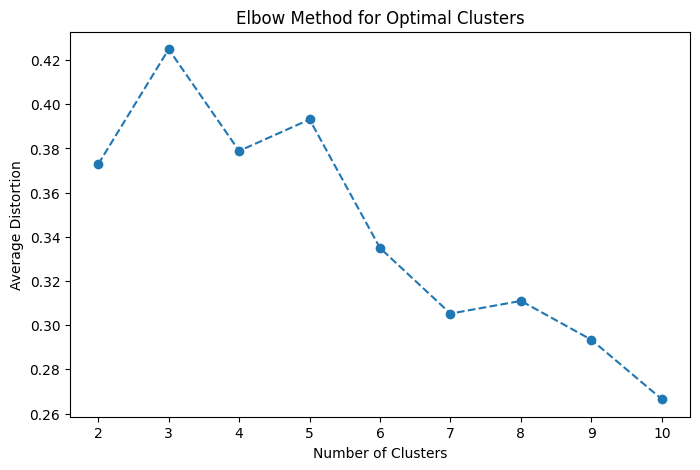

[0.37284401063006567,
 0.42488937067944715,
 0.37884695307944083,
 0.393104558424,
 0.33491296713152746,
 0.30523333121180624,
 0.3109788740171165,
 0.293384378676052,
 0.2664787699486916]

In [20]:
# Plot elbow method to find the optimal number of clusters
plot_elbow_method(tfidf_matrix)

In [21]:
# Set the number of clusters based on the elbow plot
n_clusters = 4
summary = extractive_summary(text, n_clusters=n_clusters)
print("Extractive Summary:\n", summary)

Extractive Summary:
 Today, billions of devices are connected via the internet, forming a global network that has fostered innovation and connectivity. By understanding their capabilities and limitations, we can harness their potential to create a better world. Innovations such as quantum computing and advanced artificial intelligence promise to redefine our understanding of computation and problem-solving. This involves a sequence of electrical signals that represent the numbers 0 and 1.


**Approach 2: Dynamically selecting the number of clusters**

*   The number of clusters is dynamically determined based on the elbow method.
*   The plot_elbow_method function calculates distortions for different cluster counts, and the code selects the optimal cluster count automatically by finding the "elbow" in the distortion graph.
*   The elbow point is where the distortion starts to decrease at a slower rate, suggesting the optimal number of clusters.
*   The elbow plot is calculated for the entire range (1 to 10) and used to dynamically choose the best number of clusters. It analyzes the change in distortions (np.diff) and automatically selects the optimal number of clusters, which can be more efficient in finding the best number of clusters.
*   The centroid of the cluster is computed, and the sentence closest to the centroid (based on cosine distance) is selected. The sentences are then sorted based on their relevance (cosine similarity score) and added to the summary in that order. This adds a layer of ranking by relevance.
*   Calculates the cosine distance to the centroid for each cluster and selects the sentence closest to the centroid. This allows for a more precise selection of key sentences based on their relevance to the cluster's central theme.
*   Converts the sparse TF-IDF matrix to a dense format (toarray()) for clustering and centroid calculation, which could result in higher memory consumption for larger texts.









In [22]:
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
def plot_elbow_method(tfidf_matrix, max_clusters=10):
    distortions = []
    dense_tfidf = tfidf_matrix.toarray()  # Convert sparse matrix to dense

    for n_clusters in range(1, max_clusters + 1):
        clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
        clustering_model.fit(dense_tfidf)

        cluster_distortions = []
        for label in set(clustering_model.labels_):
            cluster_points = dense_tfidf[np.array(clustering_model.labels_) == label]
            centroid = cluster_points.mean(axis=0, keepdims=True)  # Keepdims to maintain shape
            cluster_distortions.append(cdist(cluster_points, centroid, metric="cosine").mean())

        distortions.append(np.mean(cluster_distortions))

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title("Elbow Method for Optimal Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Distortion")
    plt.show()

    return distortions

In [25]:
def extractive_summary(text, max_clusters=10):
    # Tokenize text into sentences
    sentences = sent_tokenize(text)

    # Compute TF-IDF representation of the sentences
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Find the optimal number of clusters dynamically
    distortions = plot_elbow_method(tfidf_matrix, max_clusters=max_clusters)

    # Automatically determine the optimal number of clusters by checking the "elbow"
    diffs = np.diff(distortions)
    optimal_clusters = np.argmin(diffs) + 2  # Elbow appears at the point where the drop in distortion is largest

    # Perform hierarchical clustering
    dense_tfidf = tfidf_matrix.toarray()  # Convert sparse matrix to dense
    clustering_model = AgglomerativeClustering(n_clusters=optimal_clusters, metric='cosine', linkage='average')
    clustering_model.fit(dense_tfidf)

    # Extract representative sentences for each cluster
    summary_sentences = []
    selected_indices = set()
    for label in range(optimal_clusters):
        cluster_indices = [i for i, lbl in enumerate(clustering_model.labels_) if lbl == label]
        cluster_vectors = dense_tfidf[cluster_indices]
        centroid = cluster_vectors.mean(axis=0, keepdims=True)
        similarity_scores = cdist(cluster_vectors, centroid, metric="cosine").flatten()

        # Select the sentence closest to the centroid
        representative_idx = cluster_indices[np.argmin(similarity_scores)]
        if representative_idx not in selected_indices:
            summary_sentences.append((similarity_scores.min(), sentences[representative_idx]))
            selected_indices.add(representative_idx)

    # Sort selected sentences by relevance
    summary_sentences.sort(key=lambda x: x[0])  # Sort by similarity score
    summary = " ".join([sent for _, sent in summary_sentences])
    return summary

In [26]:
# Example usage
with open("computer_lecture.txt", "r") as file:
    text = file.read()

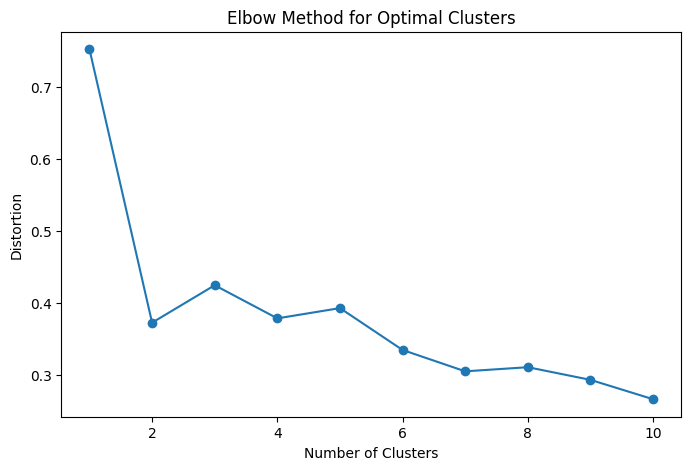

Extractive Summary:
 This involves a sequence of electrical signals that represent the numbers 0 and 1. However, the widespread use of computers is not without challenges.


In [27]:
summary = extractive_summary(text, max_clusters=10)
print("Extractive Summary:\n", summary)